# CBECS Energy Consumption Analysis: Final Summary

## 1. Introduction

This notebook summarizes the results of a project to predict commercial building energy consumption using the 2018 Commercial Buildings Energy Consumption Survey (CBECS) dataset. The primary goal is to identify the key drivers of energy use and build an accurate predictive model.

Predicting energy consumption is crucial for building owners, utilities, and policymakers to benchmark performance, identify opportunities for energy efficiency improvements, and support broader climate goals. This analysis compares several modeling techniques, from simple linear models to more complex ensembles, to determine the most effective approach.

## 2. Data Overview and Preparation

The analysis is based on the **CBECS 2018** microdata. The target variable for this project is `MFBTU`, which represents the total annual energy consumption from all major fuels in thousands of BTUs.

### Target Variable Transformation
As seen in the exploratory data analysis, the `MFBTU` variable is highly right-skewed. To stabilize variance and make the distribution more suitable for linear models, a log transformation was applied. The new target variable, `LOG_MFBTU`, was used for all modeling efforts.

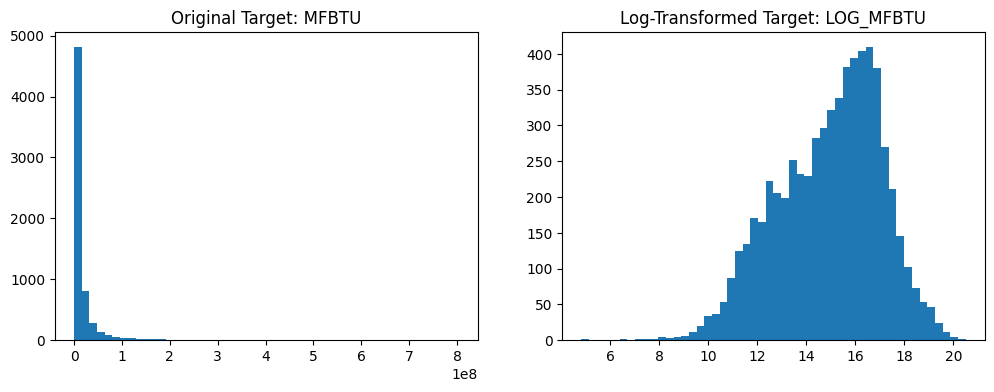

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import yaml

PROJ = pathlib.Path().resolve().parent
CFG  = yaml.safe_load(open(PROJ / 'conf' / 'config.yaml'))
RAW_DIR = PROJ / CFG['data']['raw_dir']

df = pd.read_csv(RAW_DIR / 'cbecs_2018_microdata.csv')
df['LOG_MFBTU'] = np.log(df['MFBTU'])

fig, ax = plt.subplots(1,2, figsize=(12,4))
df['MFBTU'].dropna().hist(ax=ax[0], bins=50)
ax[0].set_title('Original Target: MFBTU')
df['LOG_MFBTU'].dropna().hist(ax=ax[1], bins=50)
ax[1].set_title('Log-Transformed Target: LOG_MFBTU')
for a in ax:
    a.grid(False)
plt.show()

### Preprocessing and Feature Engineering

A comprehensive data cleaning and feature engineering pipeline was developed, which included:

- **Handling Missing Values:** Imputing or creating indicator variables for missing data based on context from the CBECS codebook.
- **Recoding Special Values:** Standardizing coded values (e.g., for confidentiality or top-coding) into meaningful numeric representations.
- **Feature Transformation:** Applying log or square-root transforms to skewed numeric features (e.g., `SQFT` -> `SQFT_log1p`).
- **One-Hot Encoding:** Converting categorical variables into a machine-readable format.
- **Data Splitting:** The final dataset was split into training (80%), validation (10%), and test (10%) sets to ensure robust model evaluation.

## 3. Modeling Approach

A variety of models were trained and evaluated to find the best predictor of energy consumption. The models were chosen to span a range of complexity and interpretability:

- **Baseline Models:** A simple `Mean Predictor` and a `Single-Feature Linear Regression` (using log-transformed square footage) were used to establish a minimum performance threshold.
- **Regularized Linear Model:** A `Lasso` regression model was chosen for its ability to perform feature selection by shrinking some coefficients to zero, leading to a more interpretable model.
- **Ensemble Models:** `Random Forest` and `XGBoost` regressors were used to capture complex, non-linear relationships and interactions between features.

## 4. Model Performance and Comparison

The following table summarizes the performance of the final models on the held-out **test set**. The key metric for comparison is the R-squared (R²), which measures the proportion of the variance in the target variable that is predictable from the independent variables.

In [2]:
import json
import pandas as pd
import pathlib

PROJ = pathlib.Path().resolve().parent
with open(PROJ / 'notebooks' / 'artifacts' / 'model_metrics.json', 'r') as f:
    metrics = json.load(f)

df_metrics = pd.DataFrame(metrics)
df_test_metrics = df_metrics[df_metrics['split'] == 'test'].copy()
df_test_metrics['r2'] = df_test_metrics['r2'].round(4)
df_test_metrics['mse'] = df_test_metrics['mse'].round(4)

df_display = df_test_metrics[['model', 'r2', 'mse']].rename(columns={'model': 'Model', 'r2': 'R-squared (Test)', 'mse': 'MSE (Test)'})
df_display = df_display.sort_values('R-squared (Test)', ascending=False).reset_index(drop=True)

display(df_display)

,Model,R-squared (Test),MSE (Test)
0,xgb_final,0.9365,0.2701
1,lasso_final,0.9344,0.2794
2,LR[SQFT_log1p],0.8234,0.7516
3,baseline_mean,-0.0075,4.2872


## 5. Feature Importance Analysis

Understanding which features drive the model's predictions is as important as the model's accuracy. Both the Lasso and Random Forest models provide methods for evaluating feature importance.

### Lasso Feature Importances

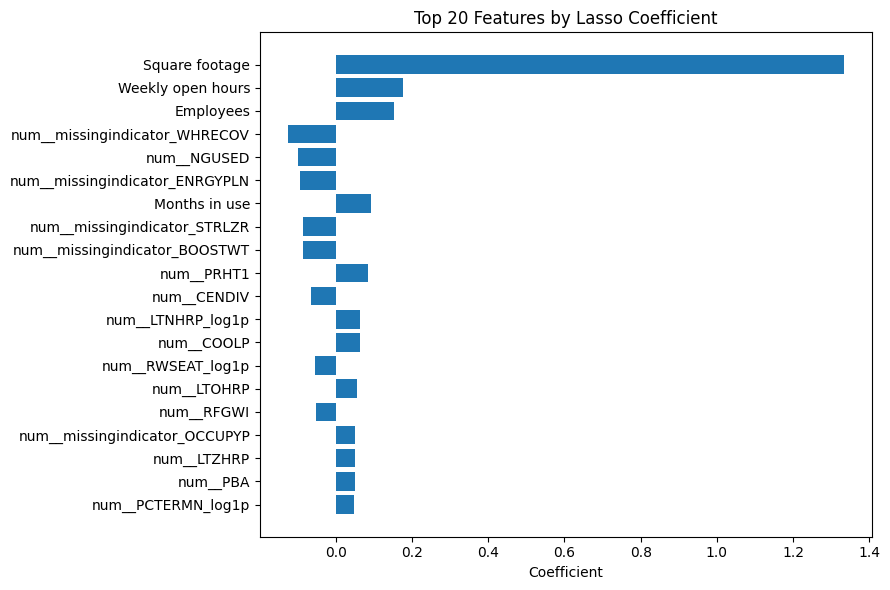

In [3]:
import joblib

PROJ = pathlib.Path().resolve().parent
final_lasso = joblib.load(PROJ / 'artifacts' / 'model_lasso.joblib')

pre = final_lasso.named_steps['preproc']
mod = final_lasso.named_steps['model']

feature_names = pre.get_feature_names_out()
coefs = mod.coef_.ravel()

coef_df = pd.DataFrame(
    {
        'feature': feature_names,
        'coef': coefs,
        'abs_coef': np.abs(coefs),
        'nonzero': coefs != 0.0, 
    }
).sort_values('abs_coef', ascending=False).reset_index(drop=True)

readable_map ={
    'num__SQFT_log1p': 'Square footage',
    'cat__PBA_4': 'Primary Use: Laboratory',
    'cat__PRHT1_1': 'Propane for main heat: Yes',
    'cat__PBA_6': 'Primary Use: Food sales',
    'cat__PBA_5': 'Primary Use: Nonrefrigerated warehouse',
    'cat__BOOSTWT_nan': 'Booster water heater: Missing',
    'cat__ENRGYPLN_nan': 'Energy mgmt plan: Missing',
    'cat__WHRECOV_nan': 'Waste heat recovery: Missing',
    'cat__NGUSED_1': 'Natural gas used: Yes',
    'cat__VAV_nan': 'Variable Air Volume system: Missing',
    'num__NWKER_log1p': 'Employees',
    'num__WKHRS_sqrt': 'Weekly open hours',
    'cat__PBA_13': 'Primary Use: Public assembly',
    'cat__MAINT_1.0': 'Regular HVAC maintenance: Yes',
    'cat__FKHT1_1': 'Fuel oil for main heat: Yes',
    'cat__DRVTHRU_0.0': 'Drive-thru: No',
    'cat__NGHT1_1': 'Natural gas for main heat: Yes',
    'cat__PBAPLUS_46': 'Primary Use: Vehicle service/repair',
    'num__missingindicator_STHWP_ST': 'Missing: % heated by district steam',
    'num__MONUSE': 'Months in use',
}

top20 = coef_df.head(20).copy()
top20['readable'] = top20['feature'].map(readable_map).fillna(top20['feature'])

plt.figure(figsize=(9, 6))
y = np.arange(len(top20))
plt.barh(y, top20['coef'].values)
plt.yticks(y, top20['readable'].values)
plt.xlabel('Coefficient')
plt.title('Top 20 Features by Lasso Coefficient')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Random Forest Feature Importances

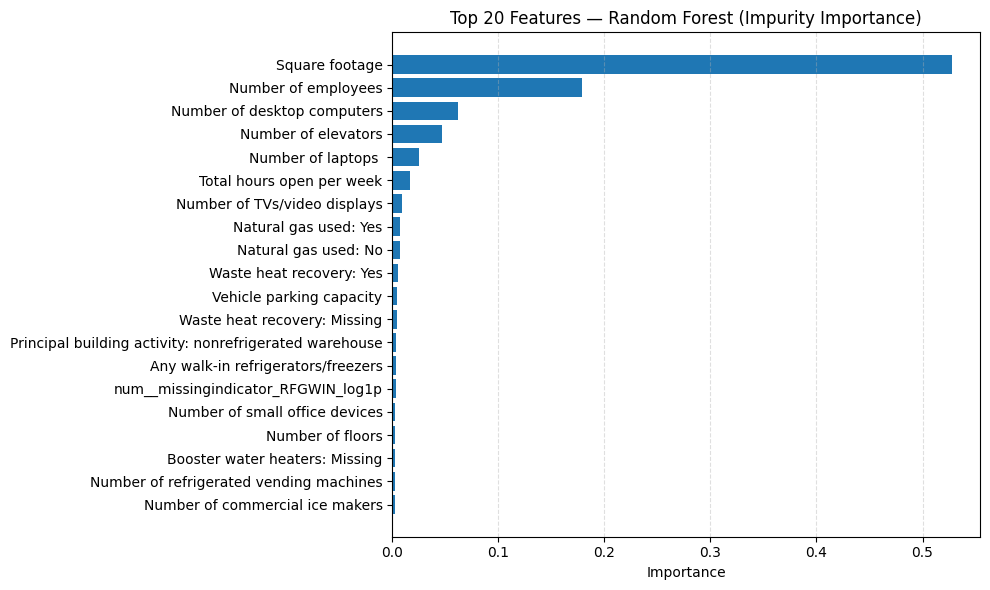

In [4]:
import pathlib
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Project root (this notebook lives in notebooks/, so parent is repo root)
PROJ = pathlib.Path().resolve().parent

# --- load fitted RF pipeline and get importances ---
# adjust this path if you saved it somewhere else
final_rf = joblib.load(PROJ / "notebooks" / "artifacts" / "model_rf.joblib")

preproc_rf = final_rf.named_steps["preproc"]
rf = final_rf.named_steps["model"]

rf_features = preproc_rf.get_feature_names_out()
rf_importances = rf.feature_importances_

rf_df = (
    pd.DataFrame({"feature": rf_features, "importance": rf_importances})
    .sort_values("importance", ascending=False)
    .head(20)
    .sort_values("importance", ascending=True)
)

rf_name_map = {
    "num__SQFT_log1p": "Square footage",
    "num__NWKER_log1p": "Number of employees",
    "num__PCTERMN_log1p": "Number of desktop computers",
    "num__NELVTR_log1p": "Number of elevators",
    "num__LAPTPN_log1p": "Number of laptops ",
    "num__NFLOOR_log1p": "Number of floors",
    "num__WKHRS_sqrt": "Total hours open per week",
    "cat__RFGWI_1.0": "Any walk-in refrigerators/freezers",
    "num__RFGWIN_log1p": "Number of walk-in refrigeration units",
    "num__RFGVNN_log1p": "Number of refrigerated vending machines",
    "num__RFGICN_log1p": "Number of commercial ice makers",
    "num__SMOFFDEVN_log1p": "Number of small office devices",
    "num__TVVIDEON_log1p": "Number of TVs/video displays",
    "num__PKLTN_sqrt": "Vehicle parking capacity",
    "cat__NGUSED_1": "Natural gas used: Yes",
    "cat__NGUSED_2": "Natural gas used: No",
    "cat__WHRECOV_2.0": "Waste heat recovery: Yes",
    "cat__WHRECOV_nan": "Waste heat recovery: Missing",
    "cat__BOOSTWT_nan": "Booster water heaters: Missing",
    "cat__PBA_5": "Principal building activity: nonrefrigerated warehouse",
}

rf_df["pretty_feature"] = rf_df["feature"].map(rf_name_map).fillna(rf_df["feature"])

plt.figure(figsize=(10, 6))
plt.barh(rf_df["pretty_feature"], rf_df["importance"])
plt.xlabel("Importance")
plt.title("Top 20 Features — Random Forest (Impurity Importance)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## 6. Conclusion and Key Takeaways

This analysis successfully developed high-performing models for predicting commercial building energy consumption, with both Lasso and XGBoost models achieving a test R² of approximately 0.936.

**Key Takeaways:**

1.  **Square Footage is King:** Across all models, the log-transformed square footage (`SQFT_log1p`) was by far the most important predictor of energy use. This confirms the fundamental principle that larger buildings consume more energy.

2.  **Model Performance:** A regularized linear model (Lasso) performed similarly to a more complex, non-linear model (XGBoost). This suggests that the primary relationships in the data are close to linear (on a log-log scale) and that the feature engineering was effective at capturing the most important signals.

3.  **Interpretability vs. Complexity:** Given its comparable performance and superior interpretability, the **Lasso model is the recommended choice**. Its sparse nature (driving many feature coefficients to zero) provides a clear and concise picture of the most influential factors.

4.  **Other Key Drivers:** Besides square footage, other important predictors include:
    - **Building Use Type:** Laboratories (`PBA_4`), food sales establishments (`PBA_6`), and warehouses (`PBA_5`) have distinct energy profiles.
    - **Operational Characteristics:** The number of workers (`NWKER_log1p`) and weekly operating hours (`WKHRS_sqrt`) are significant.
    - **HVAC and Energy Systems:** The presence of specific heating fuels (like propane or natural gas) and energy management systems also influences consumption.

## 7. Next Steps

Potential future work could include:

- **Deeper Dive into Building Types:** Analyze feature importances and model performance within specific building segments (e.g., only for office buildings or warehouses).
- **Incorporate External Data:** Augment the dataset with geographical and weather data (e.g., heating/cooling degree days) to potentially improve model accuracy.
- **Model Deployment:** Deploy the chosen Lasso model as a simple web application or API to allow users to get energy consumption estimates for their own buildings.